In [180]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import linregress
import math
import seaborn as sns

In [181]:
PEARSONBOUND = 0.5

In [182]:
basicFileName="basic_data.csv"
basicDF=pd.read_csv('../data/'+basicFileName)
basicDF.drop_duplicates(inplace=True)
basicDF['Symbol'].to_csv('../data/'+'ETFs.csv',index=False)


In [183]:
def firstSelect(df):
    
    #Inception记录股票上市时间
    firstDF=df[['Symbol','Fund Name','Assets','Category','Index','Inception','Volume',"Leverage"]]
    print(len(firstDF))
    firstDF.dropna(inplace=True,subset=['Category'])
    firstDF.dropna(inplace=True,subset=['Index'])
    firstDF.dropna(inplace=True,subset=['Assets'])
    print(len(firstDF))

    category_counts=firstDF['Category'].value_counts()
    firstDF=firstDF[firstDF['Category'].isin(category_counts[category_counts>5].index)]
    firstDF = firstDF.loc[firstDF.groupby(['Category','Index'])['Assets'].idxmax()]
    firstDF = firstDF.loc[firstDF['Leverage']=="Long"]
    firstDF = firstDF[~firstDF["Symbol"].isin(['Target Maturity', 'Muni Target Maturity'])]
    
    # print(firstDF["Leverage"].unique())
    
    # firstDF = firstDF.loc[firstDF.groupby('Index')['Assets'].idxmax()]
    # 重置索引（可选）
    firstDF = firstDF.reset_index(drop=True)

    print(len(firstDF))

    firstDF[['Index','Symbol']].to_csv("./111.csv")
    return firstDF
    

firstDF=firstSelect(basicDF)

3963
2136
1731


/tmp/ipykernel_3158792/3202117713.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstDF.dropna(inplace=True,subset=['Category'])
/tmp/ipykernel_3158792/3202117713.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstDF.dropna(inplace=True,subset=['Index'])
/tmp/ipykernel_3158792/3202117713.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstDF.dropna(inplace=True,subset=['Assets'])


In [184]:
#计算每类股票的资产总和
def category_assets(df):
    require_colums= ["Category","Assets"]
    for col in require_colums:
        if col not in firstDF.columns:
            print("Error: Missing column "+col)
            return

    df["Assets"]=pd.to_numeric(df["Assets"],errors='coerce')
    categorys=df.groupby("Category")["Assets"].sum().reset_index()
    categorys=categorys.sort_values("Assets",ascending=False)
    
    print("\nNet Assets by Category:\n")
    
    
    categorys.to_csv("../data/category_assets.csv")
    return categorys

categorys=category_assets(firstDF)
categorys.to_csv("../data/categorys.csv")
print(categorys["Category"])
# print(categorys[categorys["Category"]=="Large Blend"])


Net Assets by Category:

38               Large Blend
39              Large Growth
40               Large Value
18       Foreign Large Blend
66                Technology
               ...          
67    Trading--Miscellaneous
64       Tactical Allocation
53       Nontraditional Bond
60           Single Currency
14             Equity Hedged
Name: Category, Length: 70, dtype: object


In [185]:
#Setp3:删除流动性和资产小于 val 的基金



def filter_fund(df,categorys):
    #决定使用哪种方式保留ETF
    #0表示绝对数额，1表示百分比
    method=1
    
    
    
    filtered_df = df.copy()
    require_colums= ["Category","Assets","Volume"]
    for col in require_colums:
        if col not in firstDF.columns:
            print("Error: Missing column "+col)
            return

    totAssets=categorys["Assets"].sum()
    print("Total Assets: ",totAssets)
        
    cateVal={"-1":-1}
    for etf in df["Category"]:
        cateVal[etf]=categorys[categorys["Category"]==etf]["Assets"].values[0]
    
    df["calval"]=df["Category"].map(cateVal)
    
    # 保留Assets大于0.1%总资产的基金和大于5%该类资产的基金
    if(method==0):
        
        filtered_df = df[
            (df['Assets'] > 0.001 * totAssets) |
            (df['Assets'] > df['Category'].map(lambda ca: 0.05 * cateVal.get(ca, 0)))
        ]
    
    if(method==1):
        # 第一步：计算全局的 Assets 后 10% 阈值
        global_threshold = filtered_df['Assets'].quantile(0.1)

        # 第二步：对每个 Category 计算 Assets 后 25% 的阈值
        category_thresholds = filtered_df.groupby('Category')['Assets'].transform(lambda x: x.quantile(0.25))

        # 第三步：过滤掉满足任一条件的股票
        filtered_df = filtered_df[~((filtered_df['Assets'] <= category_thresholds) | (df['Assets'] <= global_threshold))]

    
    # filtered_df = filtered_df[~filtered_df['Category'].str.contains('Leverage', na=False)]
    filtered_df.to_csv("../data/filter_fund.csv")
    
    filtered_df["Symbol"].to_csv("../data/ETF1s.csv",index=False)
    return filtered_df

secondDF=filter_fund(firstDF,categorys)
categorys=category_assets(firstDF)
print(len(secondDF))
secondDF["Symbol"].to_csv("./ETF2.csv",index=False)

Total Assets:  7693567644440.0

Net Assets by Category:

1267


In [186]:
# linear_regression(SPY,ETF)
# find alpha and beta and 皮尔逊相关系数

def linear_regression_time(basicDf1,basicDf2,st,et):
    st=pd.to_datetime(st).date()
    et=pd.to_datetime(et).date()
    
    # basicDf1["Date"]=pd.to_datetime(basicDf1["date"]).dt.date
    # basicDf2["Date"]=pd.to_datetime(basicDf2["date"]).dt.date
    basicDf1=basicDf1[(basicDf1["Date"]>=st) & (basicDf1["Date"]<=et)]
    basicDf2=basicDf2[(basicDf2["Date"]>=st) & (basicDf2["Date"]<=et)]
    # common_dates=set(basicDf1['Date']).intersection(set(basicDf2['Date']))
    # common_dates=sorted(list(common_dates))
    
    # df1=basicDf1[basicDf1['Date'].isin(common_dates)]
    # df2=basicDf2[basicDf2['Date'].isin(common_dates)]
    if(len(basicDf1)<=5 or len(basicDf2)<=5):
        return np.nan,np.nan,False
    
    basicDf1.reset_index(drop=True,inplace=True)
    basicDf2.reset_index(drop=True,inplace=True)
    df1=basicDf1[['Date','close']]
    df2=basicDf2[['Date','close']]
    
    df=pd.merge(df1[['Date','close']],df2[['Date','close']],on='Date',suffixes=('_1','_2'))
    
    
    df['return1']=df1['close'].pct_change()
    df['return2']=df2['close'].pct_change()
    
    
    df=df.dropna()
    x = sm.add_constant(df['return1'])
    y = df['return2']

    model = sm.OLS(y, x).fit()
    
    alpha = model.params['const']
    beta = model.params['return1']
    
    correlation=np.corrcoef(df['return1'],df['return2'])[0,1]
    
    
    # print("Alpha:", alpha)
    # print("Beta:", beta)
    # # 绘制 SPY 和 ETF 收益率的散点图和回归线
    # plt.figure(figsize=(10, 6))
    # plt.scatter(df['return1'], df['return2'], label='Data Points', alpha=0.6)
    # plt.plot(df['return1'], alpha + beta * df['return1'], color='red', label='Regression Line')

    # # 添加图表标题和标签
    # plt.title('ETF Returns vs SPY Returns (Alpha and Beta)', fontsize=16)
    # plt.xlabel('SPY Returns', fontsize=12)
    # plt.ylabel('ETF Returns', fontsize=12)
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return alpha,beta,(abs(correlation)>PEARSONBOUND)



def linear_regression(basicDf1,basicDf2):
    basicDf1["Date"]=pd.to_datetime(basicDf1["date"]).dt.date
    basicDf2["Date"]=pd.to_datetime(basicDf2["date"]).dt.date
    common_dates=set(basicDf1['Date']).intersection(set(basicDf2['Date']))
    common_dates=sorted(list(common_dates))
    
    df1=basicDf1[basicDf1['Date'].isin(common_dates)]
    df2=basicDf2[basicDf2['Date'].isin(common_dates)]
    
    
    df1.reset_index(drop=True,inplace=True)
    df2.reset_index(drop=True,inplace=True)
    
    
    alphas=[]
    betas=[]
    correlations=[]
    for year in range(2010,2026):
        st=str(year)+'-01-01'
        et=str(year)+'-12-31'
        a,b,c=linear_regression_time(df1,df2,st,et)
        alphas.append(a)
        betas.append(b)
        correlations.append(c)
    
    alphaBeta=pd.DataFrame({'Year':range(2010,2026),'Alpha':alphas,'Beta':betas,'Correlation':correlations})
    
    # print("Alpha:", alpha)
    # print("Beta:", beta)
    # # 绘制 SPY 和 ETF 收益率的散点图和回归线
    # plt.figure(figsize=(10, 6))
    # plt.scatter(df['return1'], df['return2'], label='Data Points', alpha=0.6)
    # plt.plot(df['return1'], alpha + beta * df['return1'], color='red', label='Regression Line')

    # # 添加图表标题和标签
    # plt.title('ETF Returns vs SPY Returns (Alpha and Beta)', fontsize=16)
    # plt.xlabel('SPY Returns', fontsize=12)
    # plt.ylabel('ETF Returns', fontsize=12)
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return alphaBeta



dfSPY=pd.read_csv("../data/daily_data/SPY_daily.csv")
dfQQQ=pd.read_csv("../data/daily_data/QQQ_daily.csv")
# a,b,c=linear_regression(dfSPY,dfVOO)

In [187]:
def calculate_alpha_beta_val(alphaBeta):
    namda=0.98 #权重
    minAlpha=114.514
    minBeta=114.514
    AlphaScore=0.0
    BetaScore=0.0
    totyear=0
    for year in range(2010,2026):
        i=year-2010
        if(np.isnan(alphaBeta.loc[i,'Alpha'])):
            continue
        
        # AlphaScore+=math.pow(namda,2025-year)*(alphaBeta.loc[i,'Alpha'])
        # BetaScore+=math.pow(namda,2025-year)*(alphaBeta.loc[i,'Beta'])
        
        AlphaScore+=alphaBeta.loc[i,'Alpha']
        BetaScore+=alphaBeta.loc[i,'Beta']
        minAlpha=min(minAlpha,alphaBeta.loc[i,'Alpha'])
        minBeta=min(minBeta,alphaBeta.loc[i,'Beta'])
        totyear+=1
    
    if totyear==0:
        return np.nan,np.nan,np.nan,np.nan
    AlphaScore=AlphaScore/totyear
    BetaScore=BetaScore/totyear
    return AlphaScore,minAlpha,BetaScore,minBeta

In [188]:
def chooseGoodAlpha(df):
    goodETFs=[]
    errorETFS=[]
    SPYETF=pd.read_csv("../data/daily_data/SPY_daily.csv")
    for etf in df["Symbol"]:
        try :
            dfETF=pd.read_csv("../data/daily_data/"+etf+"_daily.csv")
        except Exception as e:
            errorETFS.append("\""+etf+"\"")
            print("Error: ",etf)
            print(e)
            continue
        if len(dfETF)<10:
            print("Empty: ",etf)
            errorETFS.append("\""+etf+"\"")
            continue
        # print(etf)
        # print(len(dfETF))
        # print(SPYETF.head())
        # print(dfETF.head())
        alphaBeta=linear_regression(SPYETF,dfETF)
        
        AlphaScore,minAlpha,BetaScore,minBeta=calculate_alpha_beta_val(alphaBeta)
        goodETFs.append([etf,AlphaScore,minAlpha,BetaScore,minBeta])
        # goodETFs.append(['short '+etf,-AlphaScore,-minAlpha,-BetaScore,-minBeta])
        
        
    errorETFS=pd.DataFrame(errorETFS,columns=['Symbol'])
    errorETFS.to_csv("../data/errorETFs.csv",index=False)
    return goodETFs

alphaBeta=chooseGoodAlpha(secondDF)

In [197]:
def selectAlphaBeta(alphaBeta):
    alphaBetaDF=pd.DataFrame(alphaBeta,columns=['ETF','Alpha','minAlpha','Beta','minBeta'])
    alphaBetaDF=alphaBetaDF[alphaBetaDF['ETF']!="MSTZ"]
    
    # 1. 筛选出 Beta > 0 的行
    filtered_df = alphaBetaDF[alphaBetaDF["Beta"] > 0]

    # 2. 计算 Alpha 的分位数（后 25% 的阈值）
    quantile_25 = filtered_df["Alpha"].quantile(0.25)

    # 3. 筛选出 Alpha 大小在后 25% 的行
    to_remove = filtered_df[filtered_df["Alpha"] <= quantile_25]

    # 4. 从原 DataFrame 中删除这些行
    alphaBetaDF = alphaBetaDF.drop(index=to_remove.index)
    return alphaBetaDF


In [198]:
alphaBetaDF=selectAlphaBeta(alphaBeta)

       ETF     Alpha  minAlpha      Beta   minBeta
0     KWEB -0.000042 -0.003455  1.168517  0.702455
1     KSTR -0.000108 -0.001438  0.351017  0.160300
2     ASHR  0.000051 -0.001137  0.631809  0.114241
4     CQQQ -0.000105 -0.001945  1.040575  0.375103
6     FLTW  0.000271 -0.000696  0.321997 -3.617459
...    ...       ...       ...       ...       ...
1262   IDU  0.000297 -0.000748  0.497733  0.153662
1263  RSPU  0.000228 -0.000695  0.502824  0.257878
1264   JXI -0.000003 -0.000557  0.600256  0.250310
1265   XLU  0.000306 -0.000846  0.479441  0.123172
1266   FXU  0.000111 -0.000747  0.604191  0.343903

[960 rows x 5 columns]


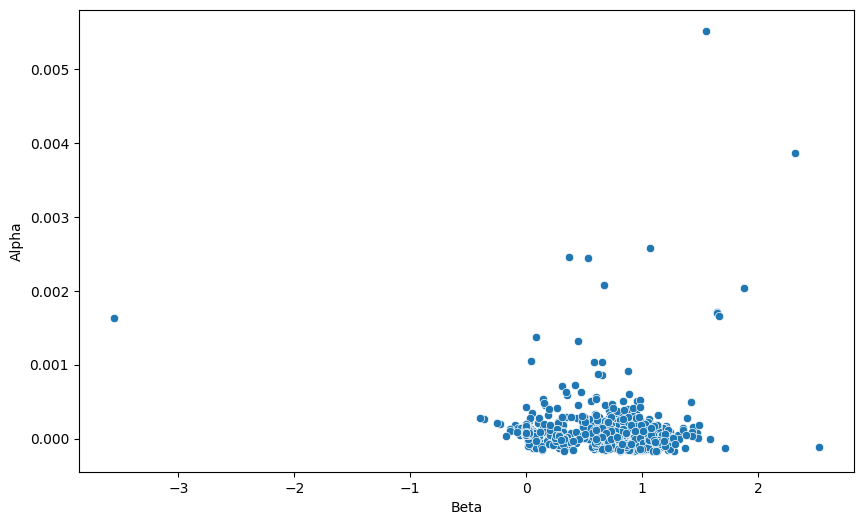

In [199]:
print(alphaBetaDF)
def drawAlphaBeta(alphaBetaDF):
    
    alphaBetaDF.to_csv("../data/alphaBeta.csv")
    plt.figure(figsize=(10, 6))
    # sns.scatterplot(x='',y='Alpha',data=alphaBetaDF)
    sns.scatterplot(x='Beta',y='Alpha',data=alphaBetaDF)
drawAlphaBeta(alphaBetaDF)

In [207]:
def findObnormal(alphaBeta):
    alphaBetaDF=pd.DataFrame(alphaBeta,columns=['ETF','Alpha','minAlpha','Beta','minBeta'])
    goodAlpha=[]
    goodBeta=[]
    nonpositiveBeta=[]
    length=len(alphaBetaDF)
    for i in range(length):
        # print(etf)
        # continue
        etf=alphaBetaDF.loc[i]
        if(etf['Alpha']<-0.001)&(etf['Beta']>0):
            goodAlpha.append(etf)
            
        if(abs(etf['Beta'])>2) :
            goodBeta.append(etf)
        if(etf['Beta']<0):
            nonpositiveBeta.append(etf)
    # print(goodAlpha)
    # print(goodBeta)
    return goodAlpha,goodBeta,nonpositiveBeta

goodAlpha,goodBeta,nonpositiveBeta=findObnormal(alphaBeta)


# print(a)

In [193]:
badETF=list(pd.DataFrame(goodAlpha,columns=['ETF'])["ETF"])
print(badETF)

finalDF=alphaBeta[~alphaBeta['ETF'].isin(badETF)]

['KCCA', 'ETHA', 'FETH', 'DAPP', 'ETHV', 'HDRO', 'GLIN', 'INFR', 'FRNW', 'MJ', 'HYDR', 'BATT', 'URNJ', 'PBW']


TypeError: list indices must be integers or slices, not str

In [201]:
print("Strange Alpha:------------------------------------------------------\n")
print(pd.DataFrame(goodAlpha))


Strange Alpha:------------------------------------------------------

       ETF     Alpha  minAlpha      Beta   minBeta
42    KCCA -0.001985 -0.011510  0.297037  0.204806
131   ETHA -0.005333 -0.009249  2.816203  2.683362
135   FETH -0.005354 -0.009319  2.812860  2.708164
140   DAPP -0.001042 -0.004652  2.789483  2.353003
142   ETHV -0.005302 -0.009196  2.812022  2.688864
208   HDRO -0.003279 -0.006562  1.247563  0.769694
479   GLIN -0.001241 -0.009255  0.966832  0.427247
519   INFR -0.001086 -0.003678  0.510901  0.104630
909   FRNW -0.001577 -0.003469  0.933057  0.704502
920     MJ -0.002020 -0.009492  0.882740  0.087760
924   HYDR -0.002918 -0.005973  1.313855  0.772499
947   BATT -0.001067 -0.002951  1.158663  0.974757
967   URNJ -0.001751 -0.004109  1.662097  1.210740
1098   PBW -0.001129 -0.005244  1.464557  0.978406


In [200]:

print("\nStrange Beta:------------------------------------------------------\n")
print(pd.DataFrame(goodBeta).sort_values('Beta'))

       ETF     Alpha  minAlpha      Beta   minBeta
1243   VXX  0.001636 -0.001450 -3.553904 -4.956095
1194  SMHX -0.000424 -0.001527  2.183636  2.092215
143   STCE -0.000199 -0.003522  2.199588  1.624706
134   ETHE  0.003872 -0.009286  2.319669  1.449714
137   FDIG -0.000177 -0.002617  2.386287  2.135227
130   BITQ -0.000118 -0.004377  2.519398  2.330627
140   DAPP -0.001042 -0.004652  2.789483  2.353003
142   ETHV -0.005302 -0.009196  2.812022  2.688864
135   FETH -0.005354 -0.009319  2.812860  2.708164
131   ETHA -0.005333 -0.009249  2.816203  2.683362


In [208]:
print("\nNegative Beta:------------------------------------------------------\n")
print(nonpositiveBeta)


Negative Beta:------------------------------------------------------

[ETF              GLD
Alpha       0.000426
minAlpha   -0.001593
Beta        -0.00251
minBeta    -0.429088
Name: 44, dtype: object, ETF             SPIP
Alpha       0.000122
minAlpha   -0.000428
Beta       -0.025727
minBeta    -0.169661
Name: 508, dtype: object, ETF             SCHP
Alpha        0.00016
minAlpha   -0.000364
Beta       -0.023633
minBeta    -0.150162
Name: 509, dtype: object, ETF             LTPZ
Alpha       0.000185
minAlpha   -0.001195
Beta       -0.099662
minBeta    -0.470096
Name: 511, dtype: object, ETF              TIP
Alpha       0.000122
minAlpha   -0.000406
Beta       -0.021673
minBeta    -0.146727
Name: 512, dtype: object, ETF              AGG
Alpha       0.000063
minAlpha   -0.000635
Beta       -0.002352
minBeta    -0.115809
Name: 526, dtype: object, ETF              BND
Alpha       0.000071
minAlpha   -0.000554
Beta       -0.008441
minBeta    -0.117637
Name: 527, dtype: object, ETF         